In [1]:
import os
os.chdir("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from utils.data import Dataset
from utils.completer import complete_by_mean_col, complete_by_multi, complete_by_similar_row
from utils.generator import gen_complete_random

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

In [4]:
# target
Y = np.random.randint(0, 2, 1000)

In [5]:
# protected attribute dependent on target to produce bias
YP_corr = 0.8
rnd_vec = np.random.randn(1000)
P = YP_corr * (Y / np.linalg.norm(Y)) + (1-YP_corr**2)**0.5 * (rnd_vec / np.linalg.norm(rnd_vec))
Pmean = P.mean()
P = np.where(P <= Pmean, P, 1)
P = np.where(P > Pmean, P, -1)

In [6]:
np.corrcoef(Y, P)

array([[1.        , 0.66805872],
       [0.66805872, 1.        ]])

In [7]:
# 3 clusters dependent on target
center0 = (0, 0)   # target 0
center1 = (0, 10) # target 1
center2 = (10, 0)   # target 1
Y_unique = np.unique(Y, return_counts=True)
Y0_size = Y_unique[1][np.where(Y_unique[0] == 0)][0]
Y1_size = Y_unique[1][np.where(Y_unique[0] == 1)][0]
X_cluster0 = np.array([*center0]) + 2.0 * np.random.randn(Y0_size, 2)
X_cluster1 = np.array([*center1]) + 2.0 * np.random.randn(Y1_size//3, 2)
X_cluster2 = np.array([*center2]) + 2.0 * np.random.randn(Y1_size-Y1_size//3, 2)
X_cluster12 = np.concatenate([X_cluster1, X_cluster2], axis=0)
np.random.shuffle(X_cluster12)
X = np.concatenate([X_cluster0, X_cluster12], axis=0)
YP = np.stack([P, Y]).T
YP = YP[YP[:, 1].argsort()]
XY = np.concatenate([X, YP], axis=1)
np.random.shuffle(XY)
X = XY[:, :-1]
Y = XY[:, -1]

In [8]:
X.shape

(1000, 3)

In [9]:
Y.shape

(1000,)

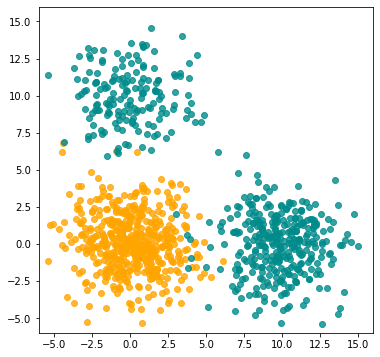

In [10]:
plt.figure(figsize=(6, 6))
plt.scatter(X[np.where(Y == 0)][:, 0], X[np.where(Y == 0)][:, 1], c="orange", alpha=0.8)
plt.scatter(X[np.where(Y == 1)][:, 0], X[np.where(Y == 1)][:, 1], c="darkcyan", alpha=0.8)
plt.xlim([-6, 16])
plt.ylim([-6, 16])
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
clf = LogisticRegression(max_iter=10000)
clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.9666666666666667

In [12]:
data = Dataset("test", pd.DataFrame(X, columns=list("ABC")), Y, protected_features=["C"])

In [13]:
data_miss = gen_complete_random(data, random_ratio=0.1)

gen_complete_random: 317 NaN values have been inserted


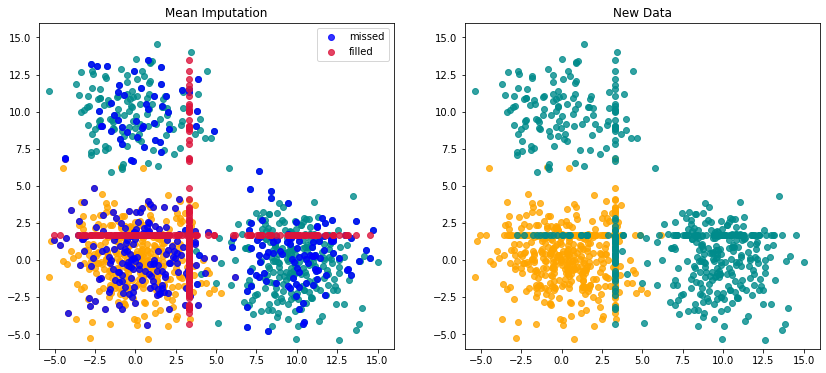

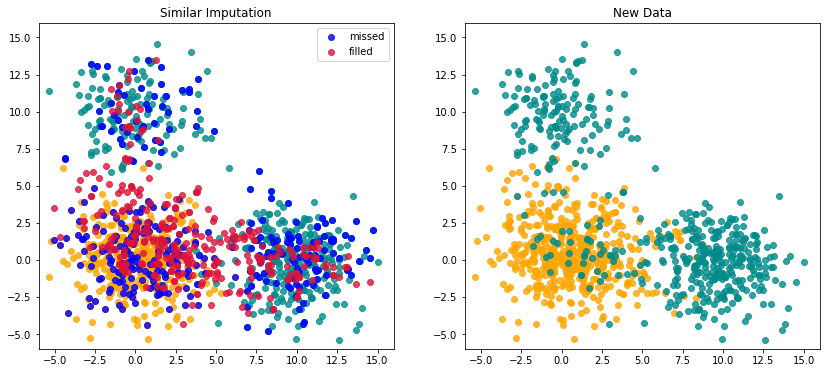

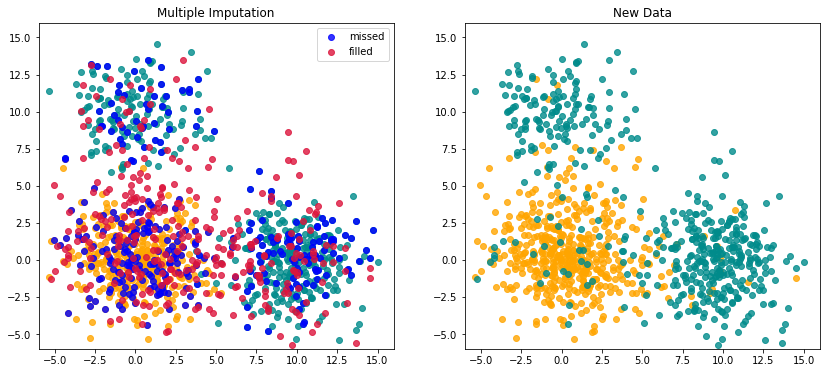

In [14]:
idx_miss = data_miss.X.isnull().sum(axis=1).to_numpy()
methods = {
    "Mean Imputation": complete_by_mean_col,
    "Similar Imputation": complete_by_similar_row,
    "Multiple Imputation": complete_by_multi,
}
for name, method_fn in methods.items():
    data_complete = method_fn(data_miss)
    if name == "Multiple Imputation": data_complete = data_complete[0]
    data_complete = data_complete.X.to_numpy()
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].scatter(X[np.where(Y == 0)][:, 0], X[np.where(Y == 0)][:, 1], c="orange", alpha=0.8)
    axes[0].scatter(X[np.where(Y == 1)][:, 0], X[np.where(Y == 1)][:, 1], c="darkcyan", alpha=0.8)
    axes[0].scatter(X[np.where(idx_miss > 0)][:, 0], X[np.where(idx_miss > 0)][:, 1], c="blue", label="missed", alpha=0.8)
    axes[0].scatter(data_complete[np.where(idx_miss > 0)][:, 0], data_complete[np.where(idx_miss > 0)][:, 1], c="crimson", label="filled", alpha=0.8)
    axes[0].set_title(name)
    axes[0].set_xlim([-6, 16])
    axes[0].set_ylim([-6, 16])
    axes[0].legend(loc="best")
    axes[1].scatter(data_complete[np.where(Y == 0)][:, 0], data_complete[np.where(Y == 0)][:, 1], c="orange", alpha=0.8)
    axes[1].scatter(data_complete[np.where(Y == 1)][:, 0], data_complete[np.where(Y == 1)][:, 1], c="darkcyan", alpha=0.8)
    axes[1].set_title("New Data")
    axes[1].set_xlim([-6, 16])
    axes[1].set_ylim([-6, 16])
    plt.show()

In [15]:
def newBias(data, A=1, B=1):
    # Pr(AA is labeled as low risk when he is actually high risk) = Pr(Caucasian is labeled as low risk when actually high risk) 
    # Pr(AA is labeled as high risk when he is low risk) =  Pr(Caucasian is labeled as high risk when actually low risk)
    # bias = |LHS - RHS|
    # A*|LHS - RHS of first type| + B*|LHS - RHS of second type|
    # A*|FPR_A - FPR_B| + B*|FNR_A - FNR_C|
    FPR_A = data[1] / (data[1] + data[0])
    FNR_A = data[2] / (data[2] + data[3])
    FPR_B  = data[5] / (data[5] + data[4])
    FNR_B  = data[6] / (data[6] + data[7])
    bias = A*abs(FPR_A - FPR_B) + B*abs(FNR_A - FNR_B)
    return bias

In [16]:
def helper_freq(array):
    """simple helper function to return the most frequent number in an array"""
    count = np.bincount(array)
    return array[np.argmax(count)]

In [17]:
# original bias
bias_orig = 0.0
for train_idx, test_idx in StratifiedShuffleSplit(n_splits=5).split(X, Y):
    X_train, X_test = data.X.iloc[train_idx], data.X.iloc[test_idx]
    Y_train, Y_test = data.y[train_idx], data.y[test_idx]
    X_train.reset_index(drop=True, inplace=True)
    X_train = X_train.drop(columns=["C"])
    X_test.reset_index(drop=True, inplace=True)
    smote = SMOTE()
    scaler = StandardScaler()
    X_train_res, Y_train_res = smote.fit_resample(X_train, Y_train)
    X_scaled = scaler.fit_transform(X_train_res)
    clf = LogisticRegression()
    clf.fit(X_scaled, Y_train_res)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test.drop(columns=["C"])), columns=X_test.drop(columns=["C"]).columns)
    X_test_scaled = pd.concat([X_test_scaled, X_test["C"]], axis=1)
    X_test_A = X_test_scaled[X_test_scaled["C"] == -1].drop(columns=["C"]).to_numpy()
    X_test_B = X_test_scaled[X_test_scaled["C"] == 1].drop(columns=["C"]).to_numpy()
    Y_test_A = Y_test[X_test_scaled[X_test_scaled["C"] == -1].index.tolist()]
    Y_test_B = Y_test[X_test_scaled[X_test_scaled["C"] == 1].index.tolist()]
    matrix_A = confusion_matrix(Y_test_A, clf.predict(X_test_A)).ravel().tolist()
    matrix_B = confusion_matrix(Y_test_B, clf.predict(X_test_B)).ravel().tolist()
    bias_orig += newBias(matrix_A+matrix_B)
bias_orig /= 5
bias_orig

0.08614624665420259